In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append('..')

import numpy as np
import librosa as lr
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pytorch_lightning import LightningModule
from scipy.signal.windows import hann
from sklearn.preprocessing import minmax_scale

from datasets.nsynth_datamodule import NsynthDataModule
from datasets.transforms import Istft, ConvToMag, ConvToDb
from models.cvae_base import CvaeBase
from models.cvae_resnet import CvaeResnet
from models.cvae_inception import CvaeInception


/home/rmicci18/miniconda3/envs/sound_morph/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
torch.cuda.set_device(2)
print(torch.cuda.current_device())


2


In [4]:
ds_configs = {
    'dataset_path': '/data/riccardo_datasets',
    'feature': 'spec',
    'feature_params': {
        'win_length': 256,
        'hop_length': 64,
        'window': hann(256)
    },
    'n_fft': 510,
    'ds_kwargs': {
        #'pitches': [60],
        #'instrument_families': [0],
        'sr': 16000,
        'duration': 1.02
    }
}

m_configs_incept = {
    'lr': 1e-4,
    'lr_scheduler': {},
    'c_labels': ['pitch'],
    'kl_coeff': 1,
    'db_coeff': 1,
    'latent_size': 32,
    'use_inception': True,
    'repeat_per_block': 1,
    'dense_size': 256,
    'channel_size': 2
}

m_configs_resnet = {
    'lr': 1e-4,
    'lr_scheduler': {},
    'c_labels': ['pitch'],
    'kl_coeff': 1,
    'db_coeff': 1,
    'latent_size': 32,
    'channel_size': 2,
    'input_height': 256,
    'enc_type': 'resnet18',
    'first_conv': False,
    'maxpool1': False,
    'enc_out_dim': 512,
}

In [5]:
# get batch of real data
bs = 8
dm = NsynthDataModule(ds_configs, num_workers=0, batch_size=bs)
dm.setup()

/home/rmicci18/miniconda3/envs/sound_morph/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


In [6]:
dl = dm.train_dataloader()
itr = iter(dl)
for i in range(4):
    a = next(itr)
ax = a[0].cuda()
ac = a[1]['pitch'].unsqueeze(dim=-1).cuda()
print(ax.shape, ac.shape)

torch.Size([8, 2, 256, 256]) torch.Size([8, 1])


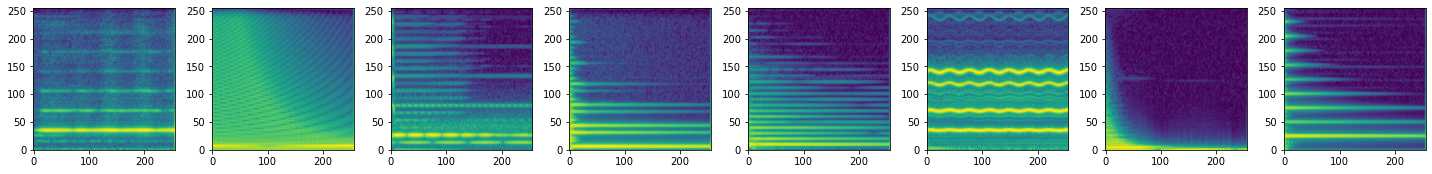

In [7]:
specs = ConvToDb()(a[0])
fig, axs = plt.subplots(1, bs, figsize=(20, 4))
for i in range(bs):
    axs[i].imshow(specs[i], origin='lower')
fig.tight_layout()

In [8]:
#m = CvaeInception.load_from_checkpoint('logs/CvaeInception_test_nopitch/version_0/checkpoints/epoch=2130-step=21309.ckpt')
#m = CvaeInception.load_from_checkpoint('logs/CvaeInception_test_nopitch2/version_0/checkpoints/epoch=11983-step=119839.ckpt')
m = CvaeInception.load_from_checkpoint('logs/CvaeInception_test_pitches/version_0/checkpoints/epoch=146-step=116423.ckpt')
#m = CvaeResnet.load_from_checkpoint('lightning_logs/version_12/checkpoints/epoch=9728-step=9728.ckpt')
m = m.cuda()

/home/rmicci18/miniconda3/envs/sound_morph/lib/python3.8/site-packages/torch/functional.py:586: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/aten/src/ATen/native/SpectralOps.cpp:602.)
  return _VF.istft(input, n_fft, hop_length, win_length, window, center,  # type: ignore


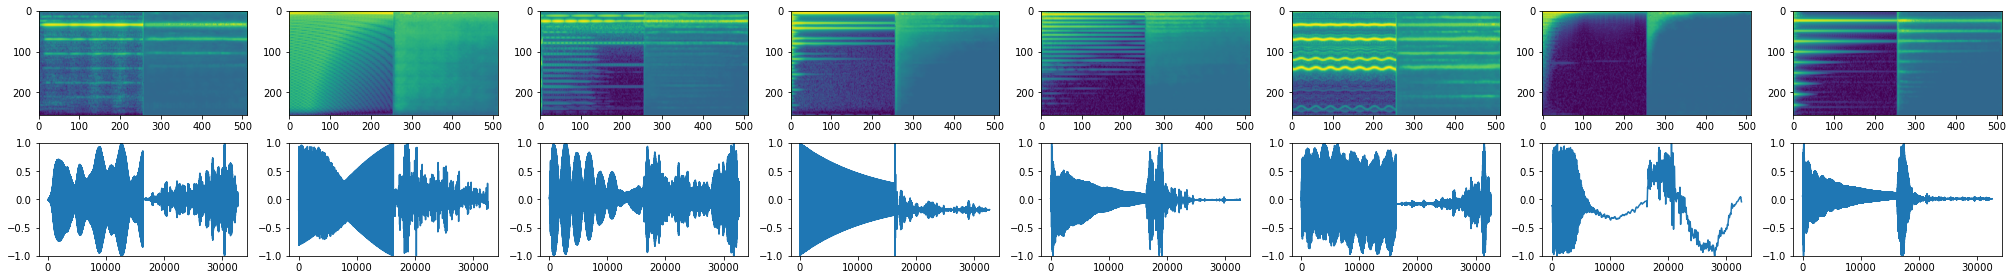

In [9]:
# run whole model
with torch.no_grad():
    x_rec, mean, log_var, z = m._shared_eval(ax, ac)

# reconstruct waveforms
xx_rec = Istft(ds_configs['n_fft'], **ds_configs['feature_params'])(x_rec)
xx_rec = xx_rec.cpu().numpy()
xx_rec = minmax_scale(xx_rec, (-1, 1), axis=1)
xx_tru = Istft(ds_configs['n_fft'], **ds_configs['feature_params'])(ax)
xx_tru = xx_tru.cpu().numpy()
xx_tru = minmax_scale(xx_tru, (-1, 1), axis=1)
xx_comparison = np.hstack([xx_tru, xx_rec])
    
# show reconstructed magnitude and waveforms
x_rec_mag = ConvToDb()(x_rec).cpu()
x_tru_mag = ConvToDb()(ax).cpu()
x_spec_comparison = np.dstack([x_tru_mag, x_rec_mag])

fig, axs = plt.subplots(2, bs, figsize=(28,4))
for i in range(bs):
    im = axs[0, i].imshow(x_spec_comparison[i])
    #fig.colorbar(im, ax=axs[0, i], shrink=.5)
    axs[1, i].plot(xx_comparison[i])
    axs[1, i].set_ylim([-1, 1])
    #ipd.display(ipd.Audio(xx_comparison[i], rate=ds_configs['ds_kwargs']['sr']))
fig.tight_layout()
plt.show()

ipd.display(ipd.Audio(np.hstack(xx_comparison), rate=ds_configs['ds_kwargs']['sr']))
# points in latent space
# TODO

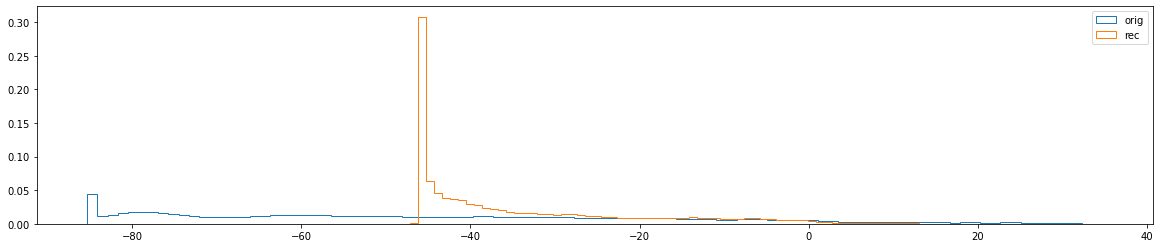

In [11]:
plt.figure(figsize=(20, 4))
plt.hist(x_tru_mag.cpu().numpy().flatten(), 100, histtype='step', density=True)
plt.hist(x_rec_mag.cpu().numpy().flatten(), 100, histtype='step', density=True)
plt.legend(['orig', 'rec'])
plt.show()

## latent space view

In [19]:
#dm.data_train.df[['instrument_family', 'instrument_family_str', 'instrument_source', 'instrument_source_str']].groupby(['instrument_source', 'instrument_family']).first()
label_lut = dm.data_train.df[['instrument_family', 'instrument_family_str']].groupby(['instrument_family']).first().to_dict()['instrument_family_str']
print(label_lut)
# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: label_lut[val])

{0: 'bass', 1: 'brass', 2: 'flute', 3: 'guitar', 4: 'keyboard', 5: 'mallet', 6: 'organ', 7: 'reed', 8: 'string', 9: 'synth_lead', 10: 'vocal'}


In [13]:
def extract_ds(dl, c_label, other_label):
    x_train = []
    c_train = []
    lbl_train = []
    z_train = []

    with torch.no_grad():
        for i in tqdm(iter(dl)):
            x_train.append(i[0])
            c = i[1][c_label].unsqueeze(dim=-1)
            c_train.append(c)
            lbl_train.append(i[1][other_label].unsqueeze(dim=-1))
            *_, z = m._shared_eval(i[0].cuda(), c.cuda())
            z_train.append(z.cpu())

    x_train = torch.vstack(x_train)
    c_train = torch.vstack(c_train)
    lbl_train = torch.vstack(lbl_train)
    z_train = torch.vstack(z_train)
    print(x_train.shape, c_train.shape, lbl_train.shape, z_train.shape)
    return x_train, c_train, lbl_train, z_train

In [15]:
#dl = dm.train_dataloader()
#x_train, c_train, lbl_train, z_train = extract_ds(dl, 'pitch', 'instrument_family')
dl = dm.test_dataloader()
x_test, c_test, lbl_test, z_test = extract_ds(dl, 'pitch', 'instrument_family')
print(z_test.shape)

100%|██████████| 512/512 [00:48<00:00, 10.49it/s]


torch.Size([4096, 2, 256, 256]) torch.Size([4096, 1]) torch.Size([4096, 1]) torch.Size([4096, 32])
torch.Size([4096, 32])


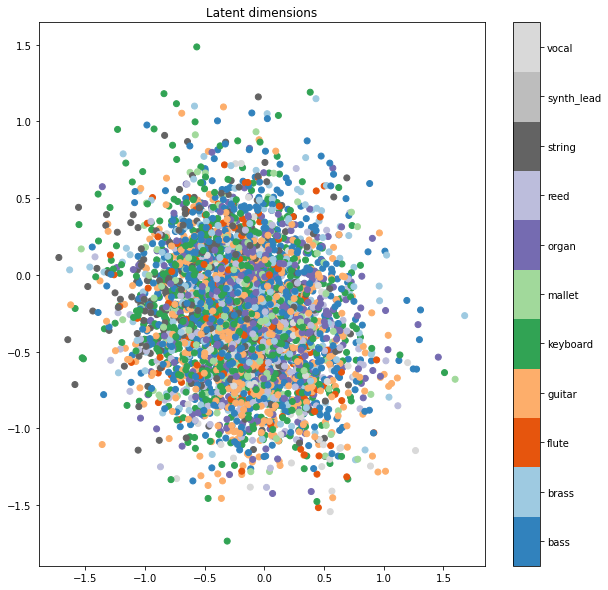

In [20]:
plt.figure(figsize=(10, 10))
sc = plt.scatter(z_test[:,0], z_test[:,1], c=lbl_test, cmap=plt.cm.get_cmap('tab20c', len(label_lut.keys())))
plt.colorbar(sc, ticks=list(label_lut.keys()), format=formatter)
plt.clim(-0.5, max(label_lut.keys()) + .5)
plt.title('Latent dimensions')
plt.show()

### T-SNE

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE()
#z_tsne_train = tsne.fit_transform(z_train)
z_tsne_test = tsne.fit_transform(z_test)

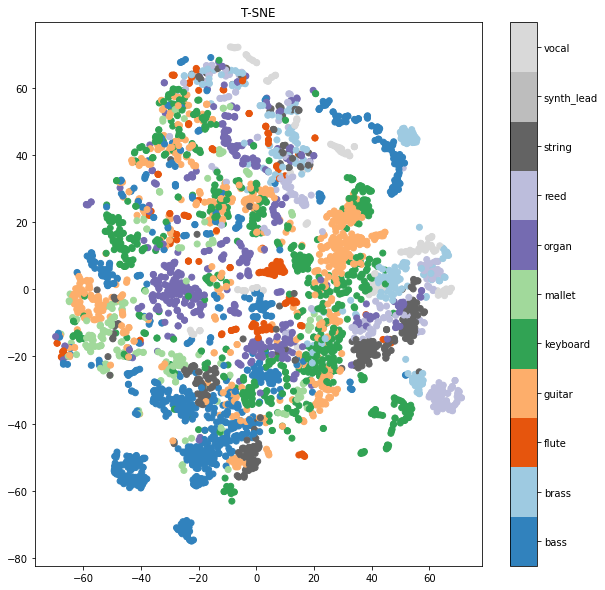

In [21]:
plt.figure(figsize=(10, 10))
sc = plt.scatter(z_tsne_test[:,0], z_tsne_test[:,1], c=lbl_test, cmap=plt.cm.get_cmap('tab20c', len(label_lut.keys())))
plt.colorbar(sc, ticks=list(label_lut.keys()), format=formatter)
plt.clim(-0.5, max(label_lut.keys()) + .5)
plt.title('T-SNE')
plt.show()

### PCA latent plot

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [23]:
pl = make_pipeline(StandardScaler(), PCA())
z_pca_train = pl.fit_transform(z_train)
z_pca_test = pl.transform(z_test)

NameError: name 'z_train' is not defined

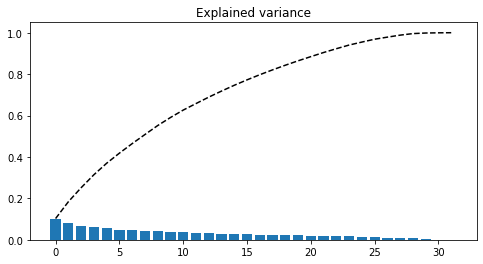

In [379]:
expl_var = pl.get_params()['pca'].explained_variance_ratio_
expl_var_sum = np.cumsum(expl_var)
pcs = np.arange(len(expl_var))

plt.figure(figsize=(8, 4))
plt.plot(pcs, expl_var_sum, '--k')
plt.bar(pcs, expl_var)
plt.title('Explained variance')
plt.show()

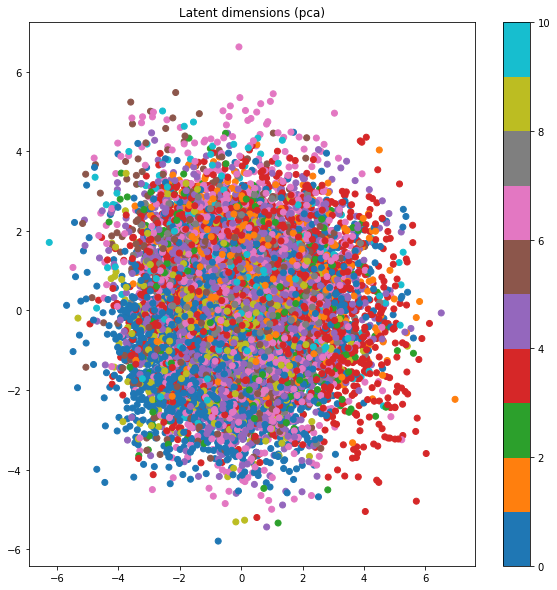

In [380]:
plt.figure(figsize=(10, 10))
sc = plt.scatter(z_pca_train[:,0], z_pca_train[:,1], c=lbl_train.cpu(), cmap='tab10')
plt.colorbar(sc)

plt.title('Latent dimensions (pca)')
plt.show()